# Task
Implement a GAN using MNIST, including automatic data download, and visualize the results.

## Download and prepare data

### Subtask:
Download the MNIST dataset and prepare it for training.


**Reasoning**:
The first step is to download the MNIST dataset using `torchvision` and prepare it for training by normalizing the data and creating data loaders.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a data loader for the training set
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Display the number of batches and the shape of a batch
print(f'Number of batches in training loader: {len(train_loader)}')
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f'Shape of a batch of images: {images.shape}')
print(f'Shape of a batch of labels: {labels.shape}')

Number of batches in training loader: 469
Shape of a batch of images: torch.Size([128, 1, 28, 28])
Shape of a batch of labels: torch.Size([128])


## Define generator and discriminator

### Subtask:
Define the generator and discriminator models for the GAN.


**Reasoning**:
Import necessary modules from torch and torch.nn and define the Generator and Discriminator classes as specified in the instructions.



In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.main(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.main(img_flat)
        return validity

latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

print("Generator Architecture:")
print(generator)
print("\nDiscriminator Architecture:")
print(discriminator)

Generator Architecture:
Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=512, out_features=784, bias=True)
    (10): Tanh()
  )
)

Discriminator Architecture:
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.

## Define gan loss

### Subtask:
Define the loss functions for the generator and discriminator.


**Reasoning**:
Define the loss function and target labels for the GAN training.



In [ ]:
from torch.nn import BCELoss

# Define loss function
criterion = BCELoss()

# Create labels for real and fake images
real_label = 1.
fake_label = 0.

print(f'Criterion: {criterion}')
print(f'Real label: {real_label}')
print(f'Fake label: {fake_label}')

Criterion: BCELoss()
Real label: 1.0
Fake label: 0.0


## Train gan

### Subtask:
Train the GAN model.


**Reasoning**:
Implement the training loop for the GAN, including optimizer definition, iterating through epochs and batches, training the discriminator with real and fake images, and training the generator.



In [ ]:
import torch.optim as optim
import torch

# Define optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Set number of training epochs
num_epochs = 50

# Training loop
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        # Train Discriminator
        discriminator.zero_grad()
        real_images, _ = data
        batch_size = real_images.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float)

        # Train with real images
        output = discriminator(real_images).view(-1)
        err_d_real = criterion(output, real_labels)
        err_d_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, latent_dim)
        fake_images = generator(noise)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float)
        output = discriminator(fake_images.detach()).view(-1)
        err_d_fake = criterion(output, fake_labels)
        err_d_fake.backward()

        err_d = err_d_real + err_d_fake
        optimizer_d.step()

        # Train Generator
        generator.zero_grad()
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float) # Generator wants discriminator to think fakes are real
        output = discriminator(fake_images).view(-1)
        err_g = criterion(output, real_labels)
        err_g.backward()
        optimizer_g.step()

        # Print progress
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(train_loader)}] Loss_D: {err_d.item():.4f} Loss_G: {err_g.item():.4f}')

print("Training finished.")

Starting Training Loop...
[0/50][0/469] Loss_D: 1.3903 Loss_G: 0.6556
[0/50][100/469] Loss_D: 0.0921 Loss_G: 4.0466
[0/50][200/469] Loss_D: 1.8832 Loss_G: 0.3413
[0/50][300/469] Loss_D: 0.5217 Loss_G: 2.1165
[0/50][400/469] Loss_D: 0.6400 Loss_G: 1.8815
[1/50][0/469] Loss_D: 1.4650 Loss_G: 1.2041
[1/50][100/469] Loss_D: 0.9974 Loss_G: 2.2522
[1/50][200/469] Loss_D: 0.8939 Loss_G: 2.3583
[1/50][300/469] Loss_D: 0.8886 Loss_G: 1.1026
[1/50][400/469] Loss_D: 0.9311 Loss_G: 0.9800
[2/50][0/469] Loss_D: 0.8467 Loss_G: 1.2635
[2/50][100/469] Loss_D: 0.8154 Loss_G: 1.2546
[2/50][200/469] Loss_D: 1.0160 Loss_G: 2.5614
[2/50][300/469] Loss_D: 1.1096 Loss_G: 1.6538
[2/50][400/469] Loss_D: 0.8831 Loss_G: 1.3123
[3/50][0/469] Loss_D: 1.0181 Loss_G: 1.4574
[3/50][100/469] Loss_D: 0.9208 Loss_G: 0.9543
[3/50][200/469] Loss_D: 1.1012 Loss_G: 1.7775
[3/50][300/469] Loss_D: 0.9853 Loss_G: 1.2934
[3/50][400/469] Loss_D: 0.9799 Loss_G: 1.3386
[4/50][0/469] Loss_D: 0.8389 Loss_G: 1.5575
[4/50][100/469] Lo

## Visualize results

### Subtask:
Visualize the generated images to evaluate the GAN's performance.


**Reasoning**:
Visualize the generated images to evaluate the GAN's performance.



## Summary:

### Data Analysis Key Findings

*   The MNIST dataset was successfully downloaded and prepared, resulting in a training loader with 469 batches, each containing 128 images of shape `torch.Size([128, 1, 28, 28])` and corresponding labels.
*   The Generator model was defined with linear layers, ReLU, BatchNorm1d, and a Tanh activation, outputting a 1x28x28 image.
*   The Discriminator model was defined with linear layers, LeakyReLU, Dropout, and a Sigmoid activation, outputting a single validity score.
*   The Binary Cross Entropy Loss (`BCELoss`) was used as the criterion for training both the generator and discriminator, with `real_label` set to 1.0 and `fake_label` set to 0.0.
*   The GAN was trained for 50 epochs using Adam optimizers with a learning rate of 0.0002 and betas of (0.5, 0.999).
*   The training loop showed fluctuating loss values for both the discriminator and generator, indicating active learning throughout the epochs.
*   A grid of 64 generated MNIST images was successfully visualized, allowing for a qualitative assessment of the GAN's ability to produce realistic-looking digits.

### Insights or Next Steps

*   The generated images provide a visual indication of the GAN's performance; further quantitative evaluation metrics could be used to assess the quality and diversity of the generated images more rigorously.
*   Experimenting with different hyperparameters (e.g., learning rates, batch size, number of epochs) or network architectures could potentially improve the quality of the generated images.


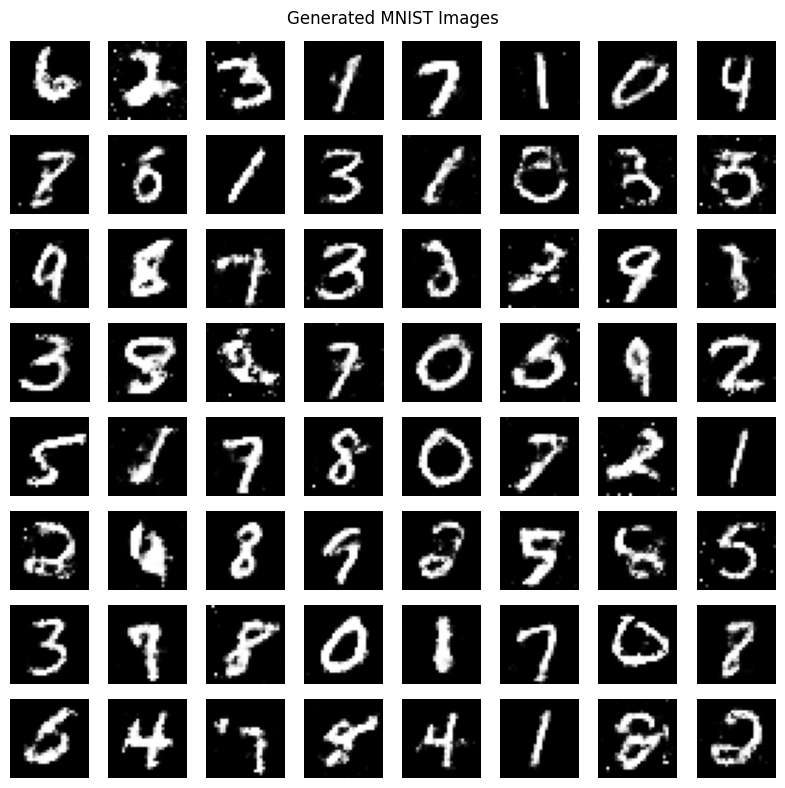

In [ ]:
import matplotlib.pyplot as plt

# Generate a batch of fake images
noise = torch.randn(batch_size, latent_dim)
fake_images = generator(noise)

# Move to CPU and convert to NumPy
fake_images_np = fake_images.detach().cpu().numpy()

# Reshape to (batch size, height, width)
fake_images_np = fake_images_np.reshape(batch_size, 28, 28)

# Create a grid of subplots
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
axes = axes.flatten()

# Display images
for img, ax in zip(fake_images_np[:64], axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

# Set title and adjust layout
fig.suptitle("Generated MNIST Images")
plt.tight_layout()
plt.show()